# Gas Turbine CO Emission Predictor
We will apply ML models to predict CO emissions from a gas turbine located in Turkey. The [dataset](https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set) used for this project was taken from the UCI machine learning repository (Heysem Kaya, 2022). It contains various measurements taken from different sensors located in a gas turbine in Turkey to study the emissions of carbon monoxide and nitrogen oxides.

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

## Loading the Data
The following table gives the description of each column along with their units.
| Name  | Description                    | Units                  |
|-------|--------------------------------|-----------------------|
| AT    | Ambient Temperature            | Celsius               |
| AP    | Ambient Pressure               | mbar                  |
| AH    | Ambient Humidity               | %                     |
| AFDP  | Air Filter Difference Pressure | mbar                  |
| GTEP  | Gas Turbine Exhaust Pressure   | mbar                  |
| TIT   | Turbine Inlet Temperature      | Celsius               |
| TAT   | Turbine After Temperature      | Celsius               |
| TEY   | Turbine Energy Yield           | Megawatt hour (MWH)   |
| CDP   | Compressor Discharge Pressure  | mbar                  |
| CO    | Carbon monoxide content        | mg/m3                 |
| NOX   | Nitrogen oxides content        | mg/mg3                |

In [59]:
df = pd.read_csv('datasets/gt_2015.csv')
print('Shape of Dataframe:', df.shape)
df.head()

Shape of Dataframe: (7384, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [60]:
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

## Data Preprocessing
Since we are focussing on the prediction of CO, we'll drop the NOx column.

In [61]:
print('Dropping column NOX...')
df = df.drop(['NOX'], axis=1)
print('Shape of Dataframe:', df.shape)
df.head()

Dropping column NOX...
Shape of Dataframe: (7384, 10)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833


### Checking for missing data and duplicates
We can see that there is no missing values or duplicate rows in our dataset.

In [62]:
print('### MISSING VALUES ###')
print(df.isnull().sum())
print()
print('### DUPLICATES ###')
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

### MISSING VALUES ###
AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
dtype: int64

### DUPLICATES ###
number of duplicate rows:  (0, 10)


### Outlier Detection

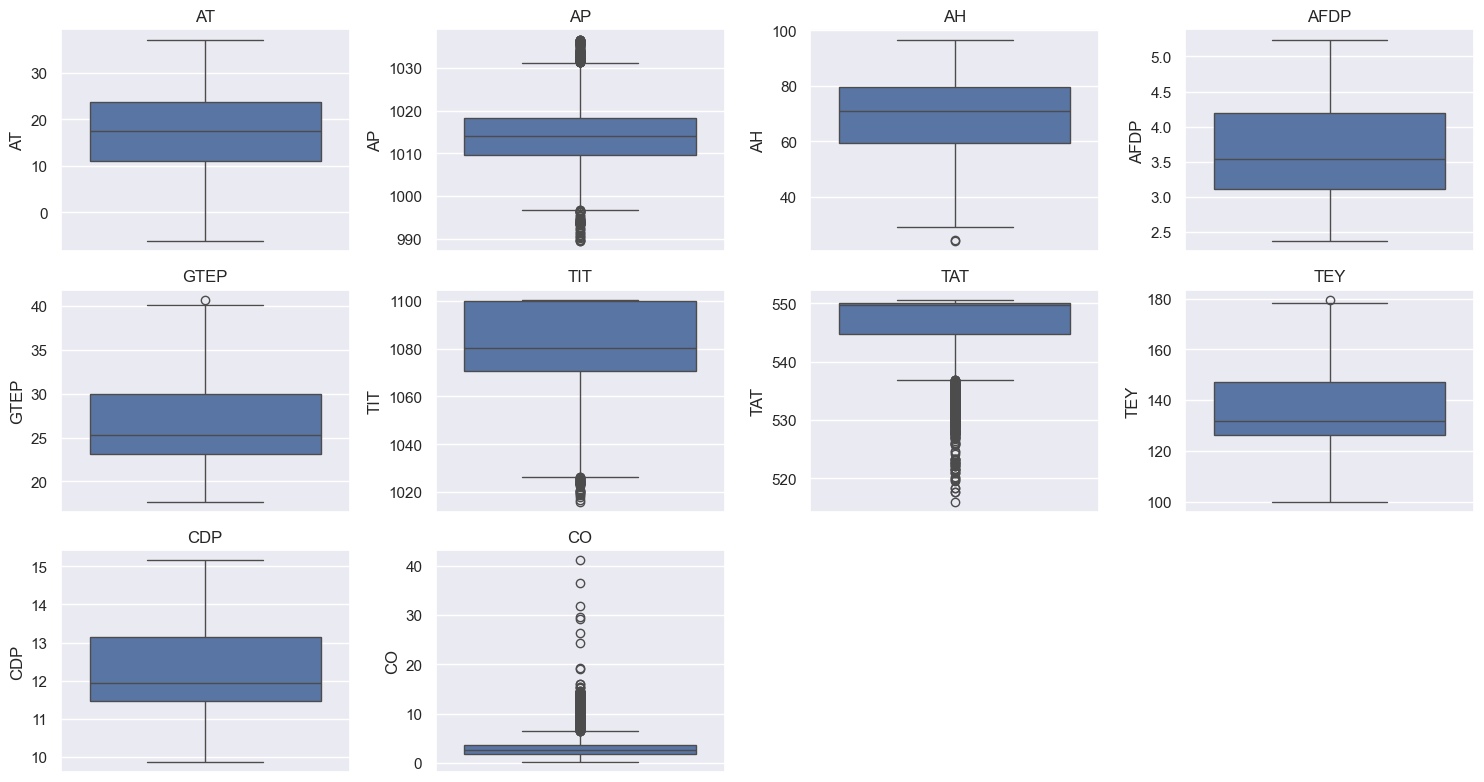

In [63]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Boxplots for each column
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Using IQR method to remove outliers

In [64]:
# Calculate Q1, Q3, and IQR
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
def outliersIQR(data):
    Q1 = data[numeric_cols].quantile(0.25)
    Q3 = data[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    # Filter out rows with outliers
    outliers = ((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    print("Number of outliers in each column:\n", outliers)
outliersIQR(df)

Number of outliers in each column:
 AT        0
AP      206
AH        2
AFDP      0
GTEP      1
TIT      38
TAT     619
TEY       1
CDP       0
CO      444
dtype: int64


In [66]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

AT      12.611500
AP       8.625000
AH      20.206500
AFDP     1.077525
GTEP     6.871250
TIT     29.400000
TAT      5.282500
TEY     20.905000
CDP      1.682250
CO       1.894375
dtype: float64


(6227, 10)

## Exploratory Data Analysis
Refer [this](https://www.kaggle.com/code/imoore/intro-to-exploratory-data-analysis-eda-in-python)